# Memory layers experiments

This notebook is a casual experimentation playground for memory layers.

**Task:** Chess move prediction.

**Model:** Transformer, SwiGLU, absolute PE, Adam, fp16.

**Representation:** UCI move sequence, as "half-moves"

e.g. `["d2d4", "f7f5", ...]` -> `["d2", "d4", "f7", "f5", ...]`

## Imports

In [1]:
# %pip install chess matplotlib pandas pyarrow seaborn tqdm torch wandb
%env WANDB_SILENT=true

import chess
from collections import OrderedDict
import copy
from dataclasses import dataclass
import itertools
import math
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import pathlib
from pathlib import Path
import seaborn as sns
import sys
import time
import tqdm
import torch
from torch import Tensor, nn
from typing import Any, Iterable, Literal
import unittest.mock
import urllib.request
import wandb

torch.serialization.add_safe_globals([pathlib.PosixPath])

class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.__dict__ = self

def _todict(x: Any) -> Any:
    if hasattr(x, "__dict__"):
        return {k: _todict(v) for k, v in x.__dict__.items()}
    return x

def _toattrdict(x: Any) -> Any:
    if isinstance(x, dict):
        return AttrDict(**{k: _toattrdict(v) for k, v in x.items()})
    return x

matplotlib.rcParams.update({
    "axes.spines.right": False,
    "axes.spines.top": False,
    "legend.edgecolor": "none",
})

env: WANDB_SILENT=true


## Config

In [2]:
S = AttrDict(
    experiment="dev",

    # Vocab
    vocab_size=8*8 + 2*8*4 + 2,  # moves + promotions + [BOS, PAD]
    pad_idx=1,

    # Model
    layers=4,
    d_model=256,
    d_ffn=3*256,
    d_head=64,
    n_head=256//64,

    # memory=None,
    memory=AttrDict(
        d_key=256,
        d_value=768,
        n_key=128,
        topk=32,
    ),

    # Training
    lr=2**-8,
    batch_size=64,
    steps=16384,
    sequence_length=512,
    valid_games=256,
    valid_interval=256,
    losses=dict(unfairness=0.01),

    # Execution & logging
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
    compile=None,
    wandb=False,
    save=None,
)

## Data

In [3]:
VOCAB = ["BOS", "PAD"] + [
    f"{col}{row}{promotion}"
    for col in "abcdefgh"
    for row in range(1, 8+1)
    for promotion in [""] + (list("bnqr") if row in [1, 8] else [])
]
assert len(VOCAB) == S.vocab_size and VOCAB[S.pad_idx] == "PAD"

def load_games() -> Tensor:
    move_to_indices = {
        m0 + m1: (i0, i1)
        for i0, m0 in enumerate(VOCAB)
        for i1, m1 in enumerate(VOCAB)
    }
    data_path = Path("data/chess_games.th")
    if not data_path.exists():
        raw_data_path = Path("data/chess_game_0001.parquet")
        if not raw_data_path.exists():
            raw_data_path.parent.mkdir(parents=True, exist_ok=True)
            urllib.request.urlretrieve("https://huggingface.co/datasets/laion/strategic_game_chess/resolve/main/chess_game_0001.parquet", raw_data_path)
        print(f"Loading {raw_data_path}", file=sys.stderr)
        games = pd.read_parquet(raw_data_path, columns=["Moves"])["Moves"]
        moves = []
        for game in tqdm.tqdm(games, desc="Tokenising moves"):
            moves.append(VOCAB.index("BOS"))
            for move in game:
                moves.extend(move_to_indices[move])
        print(f"Generating {data_path}", file=sys.stderr)
        torch.save(torch.tensor(moves, dtype=torch.uint8), data_path)
    return torch.load(data_path)

GAMES = load_games()

def batches(part: Literal["train", "valid"]) -> Iterable[Tensor]:
    game_start = torch.where(GAMES == 0)[0]
    game_length = torch.cat([game_start[1:], torch.tensor([len(GAMES)])]) - game_start
    if part == "valid":
        game_start, game_length = game_start[:S.valid_games], game_length[:S.valid_games]
        idxs = (range(i, i + S.batch_size) for i in range(0, len(game_start), S.batch_size))
    elif part == "train":
        game_start, game_length = game_start[S.valid_games:], game_length[S.valid_games:]
        idxs = (torch.randint(0, len(game_start), (S.batch_size,)) for _ in range(S.steps))
    game_length = torch.minimum(game_length, torch.tensor(S.sequence_length + 1))
    pad = VOCAB.index("PAD")
    for idx in idxs:
        yield torch.stack([
            nn.functional.pad(
                GAMES[game_start[i].item():game_start[i].item() + game_length[i].item()],
                (0, S.sequence_length + 1 - game_length[i].item()),
                value=pad
            )
            for i in idx
        ]).to(device=S.device, dtype=torch.int64)

assert next(iter(batches("valid"))).shape == (S.batch_size, S.sequence_length + 1)

In [15]:
print("Example games:")
def test():
    for game in next(iter(batches("valid")))[:2]:
        print([VOCAB[m[0]] + VOCAB[m[1]] for m in game[1:].view(-1, 2) if m[0] != S.pad_idx])
test()

Example games:
['d2d4', 'f7f5', 'g2g3', 'g7g6', 'f1g2', 'f8g7', 'g1f3', 'd7d6', 'c2c3', 'e7e6', 'a2a4', 'g8f6', 'd1c2', 'd8e7', 'b1d2', 'e6e5', 'd4e5', 'd6e5', 'e2e4', 'b8c6', 'e1g1', 'f5e4', 'd2e4', 'c8f5', 'f3d2', 'e8c8', 'b2b4', 'g7h6', 'f1e1', 'h6d2', 'c1d2', 'f6e4', 'g2e4', 'e7e6', 'd2g5', 'd8d6', 'a1d1', 'd6d1', 'e1d1', 'h7h6', 'g5e3', 'a7a5', 'c2b1', 'h6h5', 'b4b5', 'c6e7', 'e3g5', 'h8e8', 'h2h4', 'e6c4', 'd1e1', 'f5e4', 'e1e4', 'c4e6', 'g5f4', 'e6f5', 'f4e5', 'e7d5', 'b1e1', 'd5b6', 'f2f4', 'b6d7', 'e1e2', 'b7b6', 'e4e3', 'e8e7', 'e3e4', 'd7c5', 'e4d4', 'e7d7', 'g1g2', 'c8d8', 'g2h2', 'd8c8', 'e2g2', 'c8b8', 'g2a2', 'b8a7', 'a2g2', 'a7b8', 'g2e2', 'b8c8', 'e2f3', 'c8b8', 'f3d1', 'b8c8', 'd1e2', 'c8b8', 'e2d1', 'b8b7', 'd4d7', 'c5d7', 'e5d4', 'd7c5', 'h2g2', 'f5d5', 'g2g1', 'd5f5', 'd4c5', 'f5c5', 'd1d4', 'c5f5', 'd4d2', 'f5b1', 'g1f2', 'b1b3', 'd2d4', 'b3c2', 'f2e3', 'b7c8', 'd4h8', 'c8b7', 'h8d4', 'b7b8', 'd4d8', 'b8b7', 'd8d5', 'b7b8', 'd5g8', 'b8b7', 'g8c4', 'b7b8', 'c4g8', 

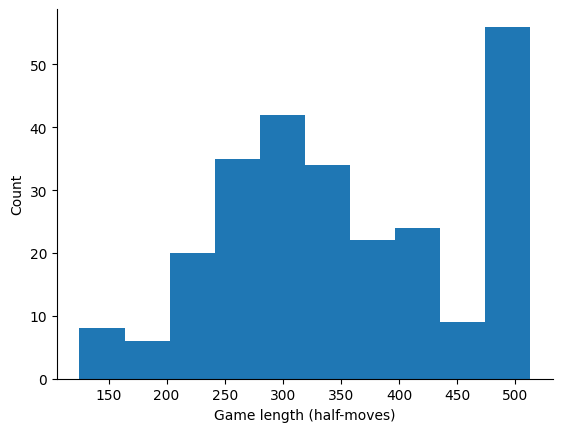

In [5]:
with plt.ion():
    _, ax = plt.subplots()
    ax.hist(torch.cat([(b != S.pad_idx).sum(-1) for b in batches("valid")]).cpu(), bins=10)
    ax.set_xlabel("Game length (half-moves)")
    ax.set_ylabel("Count")


## Model

In [14]:
class Linear(nn.Module):
    def __init__(self, in_features: int, out_features: int):
        super().__init__()
        scale = (in_features * out_features) ** (-1/4)
        self.weight = nn.Parameter(torch.randn(out_features, in_features) * scale)

    def forward(self, x: Tensor) -> Tensor:
        return x @ self.weight.T


def entropy_unfairness(indices: Tensor, n_key: int) -> Tensor:
    prob = torch.bincount(indices.flatten(), minlength=n_key).div(indices.nelement())
    return prob.mul(prob.log().nan_to_num_(0)).sum().div(torch.tensor(n_key).log()).add(1)


def entropy_unfairness_loss(gate: Tensor) -> Tensor:
    prob = gate.softmax(-1).flatten(end_dim=-2).mean(0)
    return prob.mul(prob.log().nan_to_num_(0)).sum().div(torch.tensor(gate.shape[-1]).log()).add(1)


class ProductKeyMemoryLayer(nn.Module):
    def __init__(self, s: AttrDict):
        super().__init__()
        self.topk = s.memory.topk
        self.n_key = s.memory.n_key
        self.norm = nn.RMSNorm(s.d_model)
        self.key0 = Linear(s.memory.d_key, s.memory.n_key)
        self.key1 = Linear(s.memory.d_key, s.memory.n_key)
        self.query = nn.Sequential(Linear(s.d_model, s.d_model), nn.ReLU(), Linear(s.d_model, s.memory.d_key))
        self.values = nn.Parameter(torch.randn(s.memory.n_key**2, s.memory.d_value))
        self.gate = Linear(s.d_model, s.memory.d_value)
        self.down = Linear(s.memory.d_value, s.d_model)
        self._last_idx, self._unfairness, self._unfairness_loss = None, None, None

    def layer_losses(self) -> dict[str, Tensor]:
        return dict(unfairness=self._unfairness_loss)

    def layer_metrics(self) -> dict[str, Tensor]:
        return dict(index_unfairness=self._unfairness)

    def forward(self, x: Tensor) -> Tensor:
        z = self.norm(x)

        # Sub key top-k
        query = self.query(z)
        s0 = self.key0(query)
        s1 = self.key1(query)
        tk0 = s0.topk(k=self.topk, dim=-1)
        tk1 = s1.topk(k=self.topk, dim=-1)

        # Product key top-k
        product_scores = (tk0.values.unsqueeze(-2) + tk1.values.unsqueeze(-1)).flatten(-2)
        product_idx = (tk0.indices.unsqueeze(-2) + self.n_key * tk1.indices.unsqueeze(-1)).flatten(-2)
        tkp = product_scores.topk(k=self.topk, dim=-1)

        # Lookup & combine
        weights = torch.softmax(product_scores.gather(-1, tkp.indices), dim=-1)
        values = self.values[product_idx.gather(-1, tkp.indices)]
        mix = (weights.unsqueeze(-1) * values).sum(-2)

        # Memory+ wrapper
        y = x + self.down(nn.functional.silu(self.gate(z)) * mix)

        self._last_idx = product_idx.gather(-1, tkp.indices)
        self._unfairness = entropy_unfairness(tk0.indices, self.n_key) + entropy_unfairness(tk1.indices, self.n_key)
        self._unfairness_loss = entropy_unfairness_loss(s0) + entropy_unfairness_loss(s1)
        return y


def test():
    layer = ProductKeyMemoryLayer(S)
    print(layer(torch.randn(5, 7, S.d_model)).std())
    print(layer.layer_losses())
    print(layer.layer_metrics())
test()

tensor(1.0190, grad_fn=<StdBackward0>)
{'unfairness': tensor(0.0450, grad_fn=<AddBackward0>)}
{'index_unfairness': tensor(0.1314)}


In [7]:
def aggregate_metrics(values: Iterable[dict[str, Tensor]]) -> dict[str, Tensor]:
    metrics, counts = {}, {}
    for x in values:
        for k, v in x.items():
            if k in metrics:
                metrics[k].add_(v)
                counts[k].add_(1)
            else:
                metrics[k] = v.to(torch.float32, copy=True)
                counts[k] = torch.ones((), device=v.device, dtype=torch.int64)
    return {k: v.div_(counts[k]) for k, v in metrics.items()}


class FFN(nn.Module):
    def __init__(self, s: AttrDict):
        super().__init__()
        self.norm = nn.RMSNorm(s.d_model)
        self.up = Linear(s.d_model, s.d_ffn)
        self.gate = Linear(s.d_model, s.d_ffn)
        self.down = Linear(s.d_ffn, s.d_model)

    def forward(self, x: Tensor) -> Tensor:
        z = self.norm(x)
        return x + self.down(nn.functional.silu(self.gate(z)) * self.up(z))


class Attn(nn.Module):
    def __init__(self, s: AttrDict):
        super().__init__()
        self.s = s
        self.norm = nn.RMSNorm(s.d_model)
        self.q, self.k, self.v = (Linear(s.d_model, s.n_head * s.d_head) for _ in range(3))
        self.o = Linear(s.n_head * s.d_head, s.d_model)

    def forward(self, x: Tensor, kv_cache: Tensor | None) -> Tensor:
        z = self.norm(x)
        q, k, v = (m(z).unflatten(-1, (self.s.n_head, self.s.d_head)).movedim(-2, 1) for m in [self.q, self.k, self.v])
        if kv_cache is not None:
            k_cache, v_cache = kv_cache
            k_cache[..., -k.shape[-2]:, :], v_cache[..., -v.shape[-2]:, :] = k.detach(), v.detach()
            k, v = k_cache, v_cache
        mask = torch.tril(torch.ones((q.shape[-2], k.shape[-2]), dtype=torch.bool, device=q.device), diagonal=k.shape[-2] - q.shape[-2])
        mix = nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=mask)
        return x + self.o(mix.movedim(1, -2).flatten(-2))


class PositionalEmbedding(nn.Module):
    def __init__(self, s: AttrDict):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(s.sequence_length, s.d_model))

    def forward(self, x: Tensor, offset: int) -> Tensor:
        return x + self.weight[offset:offset + x.shape[1]]


class Transformer(nn.Sequential):
    def __init__(self, s: AttrDict):
        self.s = _toattrdict(copy.deepcopy(s))
        super().__init__(OrderedDict([
            ("embed", nn.Embedding(s.vocab_size, s.d_model)),
            ("embed_pos", PositionalEmbedding(s)),
            ("trunk", nn.Sequential(*[
                nn.Sequential(OrderedDict([
                    ("attn", Attn(s)),
                    ("ffn", FFN(s) if s.memory is None or n != (s.layers//2) else ProductKeyMemoryLayer(s)),
                ]))
                for n in range(s.layers)
            ])),
            ("norm", nn.RMSNorm(s.d_model)),
            ("predict", nn.Linear(s.d_model, s.vocab_size)),
        ]))

    def forward(self, ids: Tensor, kv_cache: Tensor | None = None) -> Tensor:
        hidden = self.embed(ids)
        hidden = self.embed_pos(hidden, offset=0 if kv_cache is None else kv_cache.shape[-2] - ids.shape[1])
        for n, layer in enumerate(self.trunk):
            hidden = layer.attn(hidden, kv_cache=None if kv_cache is None else kv_cache[n])
            hidden = layer.ffn(hidden)
        hidden = self.norm(hidden)
        return self.predict(hidden)

    def _losses(self, ids: Tensor, logits: Tensor) -> Tensor:
        xent = nn.functional.cross_entropy(
            logits.flatten(end_dim=-2), ids.flatten(),
            ignore_index=self.s.pad_idx,
            reduction="mean",
        )
        other = aggregate_metrics(m.layer_losses() for m in self.modules() if hasattr(m, "layer_losses"))
        return dict(
            loss=xent + sum(v * self.s.losses[k] for k, v in other.items()),
            xent=xent,
            **other,
        )

    def _error_rate(self, ids: Tensor, logits: Tensor) -> Tensor:
        # Moves come in pairs, so use .any(-1) to measure the whole-move error rate
        errors = (logits.argmax(-1) != ids).view(-1, 2).any(-1).float()
        mask = (ids != self.s.pad_idx).view(-1, 2).any(-1).float()
        return (errors * mask).sum() / mask.sum()

    def losses(self, ids: Tensor) -> dict[str, Tensor]:
        return self._losses(ids[:, 1:], self(ids[:, :-1]).float())

    def metrics(self, ids: Tensor) -> dict[str, Tensor]:
        logits = self(ids[:, :-1]).float()
        return dict(
            **self._losses(ids[:, 1:], logits),
            error_rate=self._error_rate(ids[:, 1:], logits),
            **aggregate_metrics(m.layer_metrics() for m in self.modules() if hasattr(m, "layer_metrics")),
        )

    def create_kv_cache(self, batch_size: int) -> Tensor:
        device, = set(p.device for p in self.parameters())
        dtype, = set(p.dtype for p in self.parameters())
        return torch.full(
            (self.s.layers, 2, batch_size, self.s.n_head, self.s.sequence_length, self.s.d_head),
            torch.nan,
            device=device,
            dtype=dtype,
        )

    # Persistence

    def save(self, path: Path | str) -> None:
        Path(path).parent.mkdir(parents=True, exist_ok=True)
        data = dict(s=_todict(self.s), params=self.state_dict(), log=getattr(self, "log", None))
        torch.save(data, path)

    @classmethod
    def load(cls, path: Path) -> "Transformer":
        data = torch.load(path)
        model = cls(_toattrdict(data["s"]))
        model.load_state_dict(data["params"])
        if data["log"]:
            model.log = data["log"]
        return model


def test():
    model = Transformer(S).to(S.device, S.dtype)
    display(model.losses(next(batches("valid"))))
    display(model.metrics(next(batches("valid"))))
test()

{'loss': tensor(5.0185, device='cuda:0', grad_fn=<AddBackward0>),
 'xent': tensor(5.0180, device='cuda:0', grad_fn=<NllLossBackward0>),
 'unfairness': tensor(0.0509, device='cuda:0', grad_fn=<DivBackward0>)}

{'loss': tensor(5.0185, device='cuda:0', grad_fn=<AddBackward0>),
 'xent': tensor(5.0180, device='cuda:0', grad_fn=<NllLossBackward0>),
 'unfairness': tensor(0.0509, device='cuda:0', grad_fn=<DivBackward0>),
 'error_rate': tensor(1., device='cuda:0'),
 'index_unfairness': tensor(0.1317, device='cuda:0')}

## Training

In [11]:
def run_experiment(**config: Any) -> None:
    with unittest.mock.patch.dict(S, config):
        t0 = time.time()
        if S.wandb:
            wandb.init(project="memory-layers-demo", config=_todict(S), reinit=True)
        try:
            model = Transformer(S).to(S.device, S.dtype)
            if S.wandb:
                wandb.summary["n_params"] = sum(p.numel() for p in model.parameters())
            model.log = []

            opt = torch.optim.Adam(model.parameters(), lr=torch.tensor(S.lr, device=S.device), eps=1e-5)
            schedule = torch.optim.lr_scheduler.LambdaLR(opt, lambda n: .5*(math.cos(math.pi*n/S.steps)+1))
            grad_scale = S.batch_size * S.sequence_length
            def step_train(batch: Tensor) -> dict[str, Tensor]:
                opt.zero_grad()
                losses = model.losses(batch)
                losses["loss"].backward(torch.full_like(losses["loss"], grad_scale))
                opt.step()
                schedule.step()
                return losses
            step_valid = model.metrics
            if S.compile:
                torch.compiler.reset()
                step_train = torch.compile(step_train, mode=S.compile)
                step_valid = torch.compile(step_valid, mode=S.compile)

            progress = tqdm.tqdm(enumerate(batches("train")), total=S.steps)
            for step, batch in progress:
                losses = {k: v.clone() for k, v in step_train(batch).items()}
                model.log.append(dict(step=step, **{k: v.item() for k, v in losses.items()}, lr=schedule.get_last_lr()[0].item()))
                if step % S.valid_interval == 0 or step == S.steps - 1:
                    with torch.no_grad():
                        model.train(False)
                        metrics = aggregate_metrics(step_valid(batch) for batch in batches("valid"))
                        for k, v in metrics.items():
                            model.log[-1][f"valid_{k}"] = v.item()
                        model.train(True)
                if S.wandb:
                    wandb.log(model.log[-1])
                progress.set_postfix(loss=f"{losses['loss'].item():.3f}")
        finally:
            if S.save:
                model.save(S.save)
            if S.wandb:
                wandb.summary["duration"] = time.time() - t0
                wandb.finish()


def run_sweep(*axes: list[dict[str, Any]]) -> None:
    for ds in itertools.product(*axes):
        config = {k: v for d in ds for k, v in d.items()}
        print(config, file=sys.stderr)
        run_experiment(**config)

In [12]:
# run_sweep(
#     [dict(experiment="baseline-sweep-v0", wandb=True, memory=None, compile="max-autotune")],
#     [
#         dict(layers=2, d_model=128, d_ffn=3*128, d_head=64, n_head=128//64),
#         dict(layers=4, d_model=256, d_ffn=3*256, d_head=64, n_head=256//64),
#         dict(layers=8, d_model=512, d_ffn=3*512, d_head=64, n_head=512//64),
#     ],
#     [
#         dict(batch_size=64, steps=4096),
#         dict(batch_size=64, steps=16384),
#         dict(batch_size=256, steps=4096),
#     ],
#     [dict(lr=2**n) for n in [-10, -9, -8, -7]],
# )
# run_sweep(
#     [dict(experiment="memory-sweep-v0", wandb=True, compile="max-autotune", steps=16384)],
#     [
#         dict(layers=4, d_model=256, d_ffn=3*256, d_head=64, n_head=256//64),
#     ],
#     [
#         dict(memory=AttrDict(d_key=256, d_value=768, n_key=64, topk=16)),
#         dict(memory=AttrDict(d_key=256, d_value=768, n_key=64, topk=32)),
#         dict(memory=AttrDict(d_key=256, d_value=256, n_key=128, topk=32)),
#         dict(memory=AttrDict(d_key=256, d_value=768, n_key=128, topk=32)),
#     ],
#     [
#         dict(losses=dict(unfairness=0.0)),
#         dict(losses=dict(unfairness=0.01)),
#         dict(losses=dict(unfairness=0.1)),
#         dict(losses=dict(unfairness=1.0)),
#     ],
#     [dict(lr=2**n) for n in [-10, -9, -8, -7]],
# )
# run_sweep(
#     [dict(experiment="memory-sweep-v1", wandb=True, compile="max-autotune")],
#     [dict(lr=2**n) for n in [-10, -9, -8, -7]],
# )

In [ ]:
# config_large = dict(
#     layers=8,
#     d_model=512,
#     d_ffn=3*512,
#     d_head=64,
#     n_head=512//64,
#     lr=2**-9,
# )
# run_experiment(compile="max-autotune", **config_large, memory=None, save="data/models_large/baseline.th")
# run_experiment(compile="max-autotune", **config_large, save="data/models_large/memory.th")

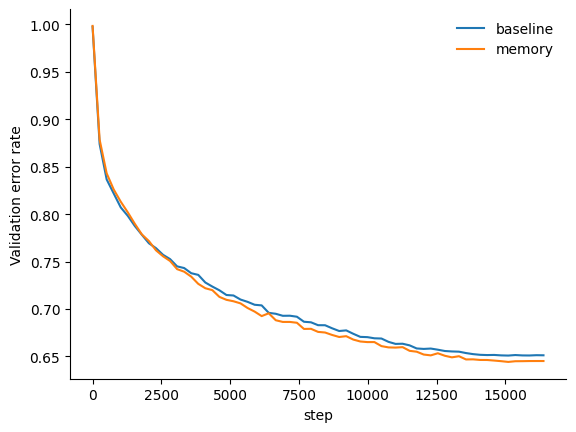

In [8]:
baseline = Transformer.load(Path("data/models_large/baseline.th")).to(S.device, S.dtype)
memory_model = Transformer.load(Path("data/models_large/memory.th")).to(S.device, S.dtype)
with plt.ion():
    _, ax = plt.subplots()
    pd.DataFrame.from_records(baseline.log).dropna(subset="valid_error_rate").plot(y="valid_error_rate", x="step", ax=ax, label="baseline")
    pd.DataFrame.from_records(memory_model.log).dropna(subset="valid_error_rate").plot(y="valid_error_rate", x="step", ax=ax, label="memory")
    ax.set_ylabel("Validation error rate");

## Inference

In [12]:
class Player:
    def __init__(self, model: Transformer, temperature: float = 1.0):
        self.model = model
        self.cache = model.create_kv_cache(1)
        self.cache_tokens = []
        self.temperature = temperature

    def __call__(self, board: chess.Board) -> str:
        tokens = [VOCAB.index("BOS")] + [VOCAB.index(h) for move in [m.uci() for m in board.move_stack] for h in (move[:2], move[2:])]
        # Note: don't consume all the tokens in the cache, or we can't re-generate logits
        cache_hit = min((n for n, (t0, t1) in enumerate(zip(self.cache_tokens, tokens)) if t0 != t1),
                        default=min(len(self.cache_tokens), len(tokens) - 1))
        sequence_length = len(tokens)
        tokens = tokens[cache_hit:]
        generated_tokens = []
        with torch.no_grad():
            for _ in range(2):
                # Generate
                logits = self.model(
                    torch.tensor([tokens], dtype=torch.int64, device=self.model.s.device),
                    kv_cache=self.cache[..., :sequence_length, :]
                )[0, -1].float()
                self.cache_tokens.extend(tokens)
                # Sample
                next_token = (logits + torch.rand_like(logits).log_().neg_().log_().neg_().mul_(self.temperature)).argmax(-1).item()
                tokens = [next_token]
                generated_tokens.append(next_token)
                sequence_length += 1

        return "".join(VOCAB[t] for t in generated_tokens)


def make_move(player: Player, board: chess.Board, max_retries: int = 25) -> None:
    for _ in range(max_retries):
        try:
            board.push_uci(player(board))
            return
        except (chess.IllegalMoveError, chess.InvalidMoveError):
            pass
    raise chess.IllegalMoveError(f"Model could not make a valid move after {max_retries} retries")


class MemoryPlot:
    def __init__(self, layer: ProductKeyMemoryLayer, decay: float, player: Player, title: str):
        n_key = layer.key0.weight.shape[0]
        self.layer = layer
        self.decay = decay
        self.player = player
        self.title = title
        self.memory = torch.zeros((n_key, n_key))
        self._imdata = None

    def update(self, ax: matplotlib.axes.Axes) -> None:
        self.memory *= self.decay
        self.memory.view(-1)[self.layer._last_idx[0, -1]] = 1
        if self._imdata is None:
            self._imdata = ax.imshow(self.memory, cmap="flare_r")
            ax.axis("off")
            ax.set_title(self.title)
            ax.set_aspect("equal")
        else:
            self._imdata.set_data(self.memory)


@dataclass
class Result:
    winner: Literal["white", "black", "stalemate"]
    reason: str  # chess.Termination | "FORFEIT" | "TOO_LONG"
    board: chess.Board


def play(white: Player, black: Player, animate: float = 0, decay: float = 0.8) -> Result:
    board = chess.Board()
    with plt.ioff():
        if animate:
            board_handle = display(board, display_id=True)
            memory_plots = []
            for label, player in [("white", white), ("black", black)]:
                for m in player.model.modules():
                    if isinstance(m, ProductKeyMemoryLayer):
                        memory_plots.append(MemoryPlot(m, decay, player, label))
            if memory_plots:
                memory_fig, memory_axs = plt.subplots(ncols=len(memory_plots), figsize=(4 * len(memory_plots), 4), squeeze=False)
                plt.close(memory_fig)
                memory_handle = display(None, display_id=True)

        t0 = time.time()
        for i in range(min(white.model.s.sequence_length, black.model.s.sequence_length) // 2):
            try:
                player = white if i % 2 == 0 else black
                make_move(player, board)
                if animate:
                    board_handle.update(board)
                    if memory_plots and i >= 1:
                        for plot, ax in zip(memory_plots, memory_axs.flatten()):
                            if plot.player is player:
                                plot.update(ax)
                        memory_fig.canvas.draw()
                        memory_handle.update(memory_fig)
                    time.sleep(max(1e-3, t0 + animate - time.time()))
                    t0 = time.time()

            except chess.IllegalMoveError:
                return Result("black" if i % 2 == 0 else "white", reason="FORFEIT", board=board)
            if outcome := board.outcome():
                return Result(
                    {chess.WHITE: "white", chess.BLACK: "black", None: "stalemate"}[outcome.winner],
                    reason=outcome.termination.name,
                    board=board,
                )
        return Result("stalemate", reason="TOO_LONG", board=board)

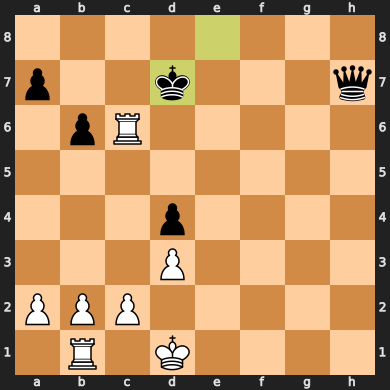

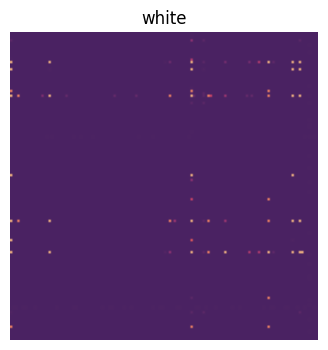

Result(winner='stalemate', reason='FIVEFOLD_REPETITION', board=Board('8/p2k3q/1pR5/8/3p4/3P4/PPP5/1R1K4 w - - 37 61'))

In [13]:
display(play(Player(memory_model), Player(baseline), animate=0.2, decay=0.8))